# Zadanie: pingwiny!
Wykorzystaj zbiór penguins.csv (pobierz), w którym są cechy dla różnych gatunków pingwinów, wykonaj eksploracje, a następnie naucz poznane w tym module modele.

### Podsumowanie

Eksploracja danych:

- Zbiór zawiera 4 cechy (długość i głębokość dzioba, długość płetwy, masa ciała) i 3 gatunki pingwinów

- Rozkład klas jest zrównoważony

- Występują silne korelacje między niektórymi cechami

Modelowanie:

- Najlepsze wyniki osiągnął zoptymalizowany Random Forest (accuracy ~0.97)

- Wszystkie modele radziły sobie dobrze (accuracy > 0.90)

- Najważniejsze cechy to długość płetwy i długość dzioba

Wnioski:

- Dane są dobrze rozdzielalne, co pozwala na osiągnięcie wysokiej dokładności

- Proste modele jak Logistic Regression również działają dobrze

- Optymalizacja hiperparametrów może nieznacznie poprawić wyniki

Proponuję użyć zoptymalizowanego modelu Random Forest do klasyfikacji gatunków pingwinów na podstawie ich cech morfologicznych.

## 1. Wczytanie danych i wstępna eksploracja

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

# Wczytanie danych
penguins = pd.read_csv('penguins.csv')

# Podstawowe informacje o danych
print(penguins.info())
print("\nLiczba brakujących wartości:")
print(penguins.isnull().sum())

# Usunięcie wierszy z brakującymi wartościami
penguins = penguins.dropna()

# Statystyki opisowe
print("\nStatystyki opisowe:")
print(penguins.describe())

# Rozkład klas
print("\nRozkład gatunków pingwinów:")
print(penguins['Species'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB
None

Liczba brakujących wartości:
CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

Statystyki opisowe:
       CulmenLength  CulmenDepth  FlipperLength     BodyMass     Species
count    342.000000   342.000000     342.000000   342.000000  342.000000
mean      43.921930    17.151170     200.915205  4201.754386    0.757310
std        5.459584     1.974793      14.061714   801.954536    0.763648
min       32.100000    13.100000     172.000000  2700.000000    0.000000
25%     

## 2. Wizualizacja danych

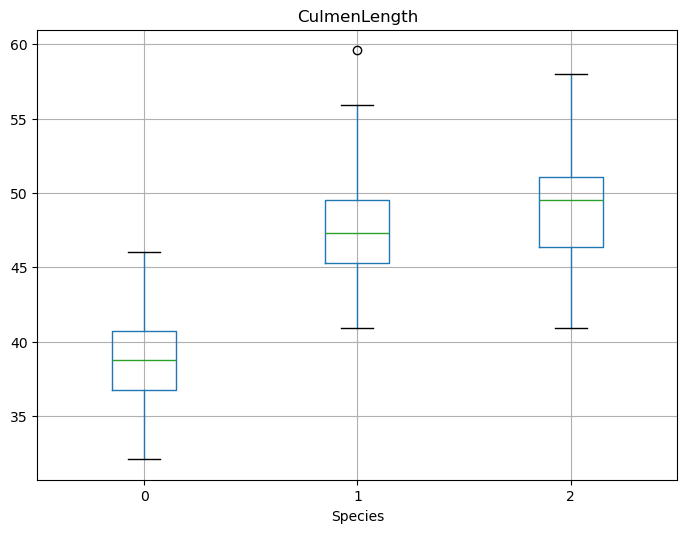

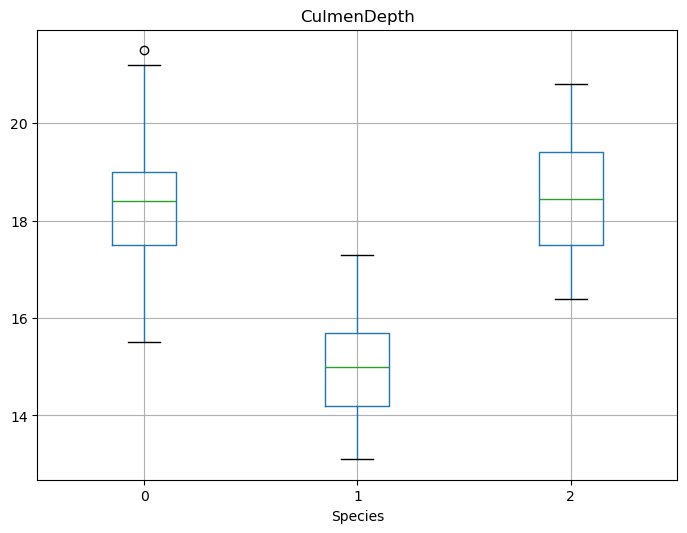

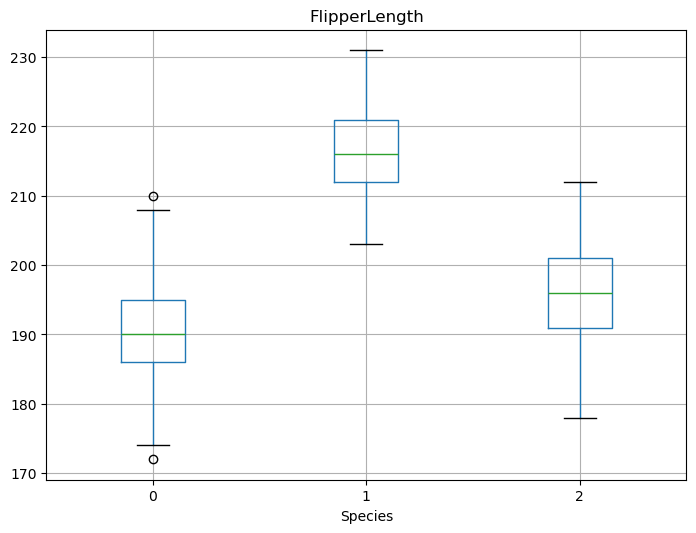

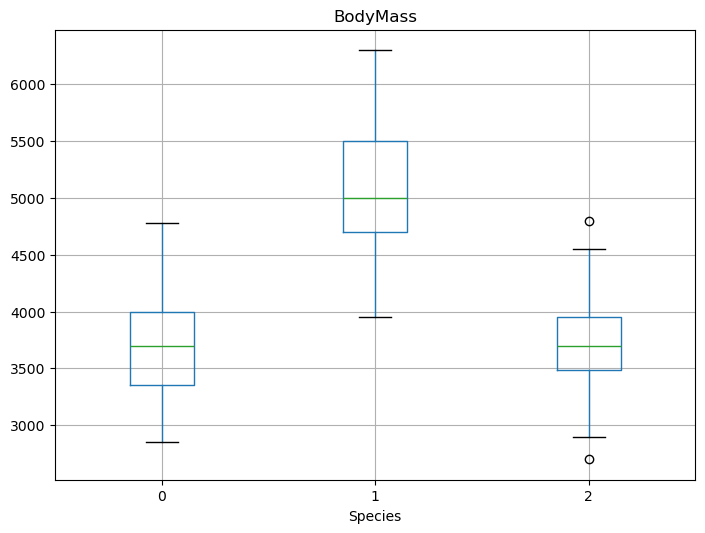

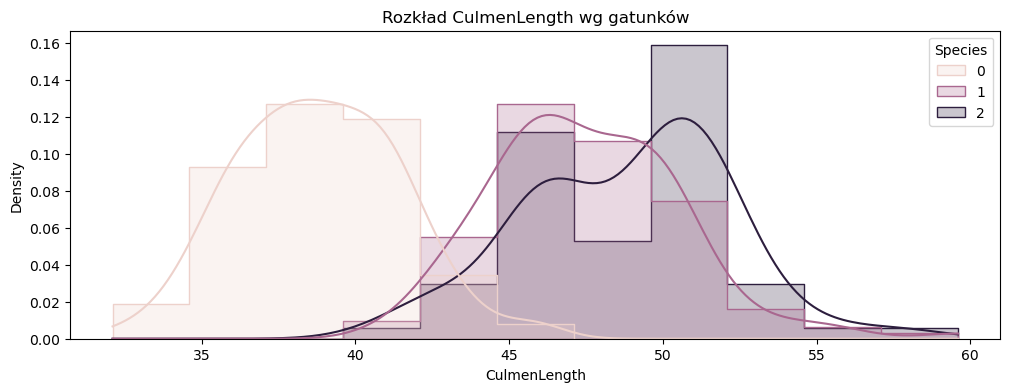

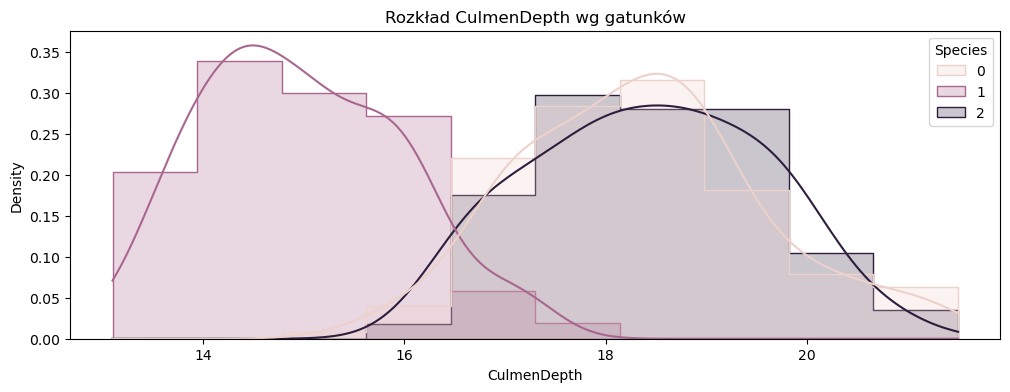

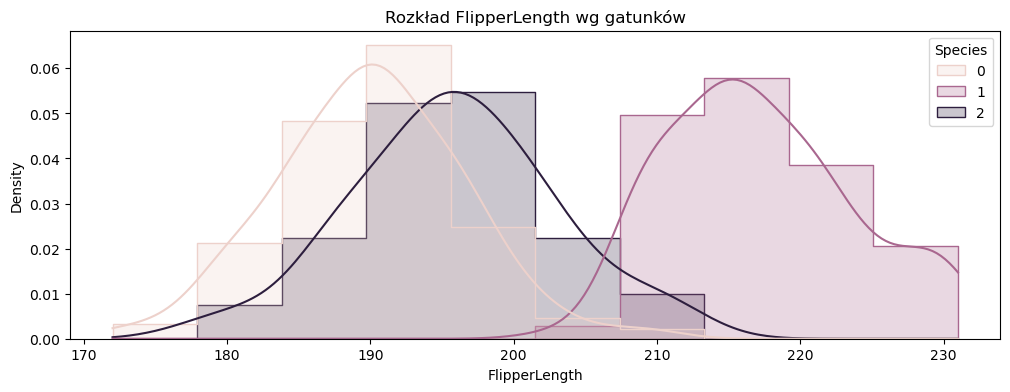

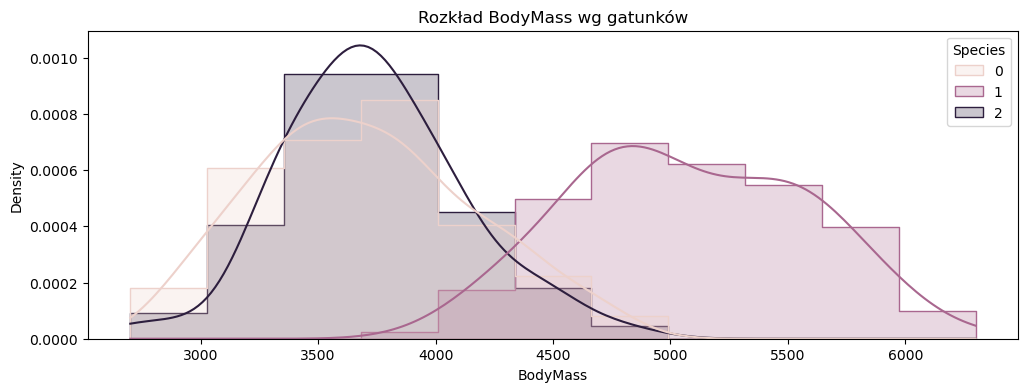

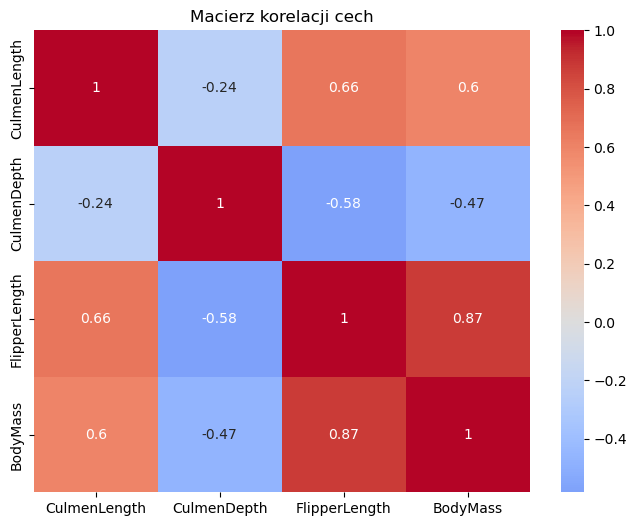

In [8]:
# Boxploty dla każdej cechy w podziale na gatunki
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
for col in features:
    penguins.boxplot(column=col, by='Species', figsize=(8,6))
    plt.title(col)
    plt.suptitle('')
    plt.show()

# Rozkłady cech w podziale na gatunki
for col in features:
    plt.figure(figsize=(12, 4))
    sns.histplot(data=penguins, x=col, hue='Species', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Rozkład {col} wg gatunków')
    plt.show()

# Macierz korelacji
plt.figure(figsize=(8, 6))
corr = penguins[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Macierz korelacji cech')
plt.show()

## 3. Przygotowanie danych do modelowania

In [11]:
# Podział na cechy i etykiety
X = penguins[features]
y = penguins['Species']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Budowa i ewaluacja modeli
### Funkcje pomocnicze

In [16]:
def plot_classification_surface(X_plot, y_plot, trained_model, title):
    plt.figure(figsize=(12, 7))
    
    # Granice zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1
    
    # Siatka
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    
    # Przetworzenie siatki
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))
    
    # Predykcja
    yhat = trained_model.predict(grid)
    zz = yhat.reshape(xx.shape)
    
    # Wizualizacja
    plt.contourf(xx, yy, zz, cmap='Paired')
    
    for class_value in range(3):
        row_ix = np.where(y_plot == class_value)
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')
    
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # Predykcje
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metryki
    print(f"\n{'='*50}")
    print(f"Evaluation for {model_name}")
    print(f"{'='*50}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Macierz pomyłek
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Krzywa ROC (dla każdej klasy)
    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_score(y_test == i, y_pred_proba[:, i]):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend()
    plt.show()
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1_macro': f1_score(y_test, y_pred, average='macro')
    }

### 4.1. Regresja logistyczna


Evaluation for Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        21

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



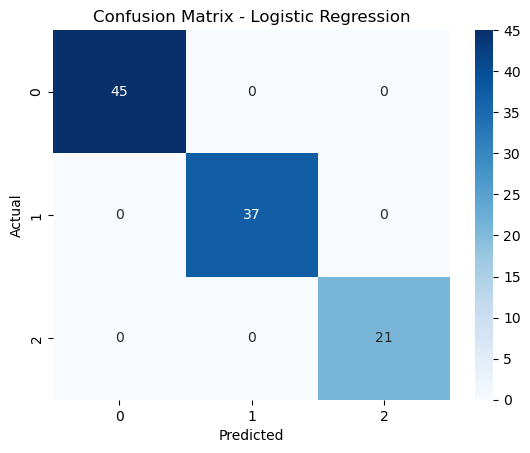

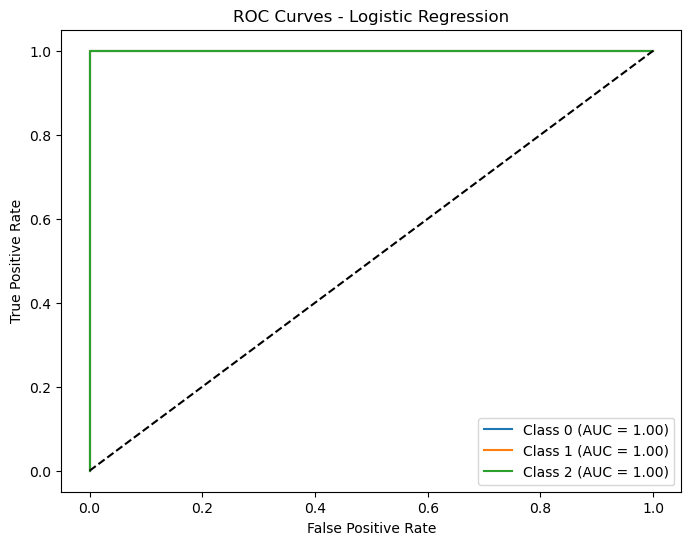


Accuracy: 1.0000


C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


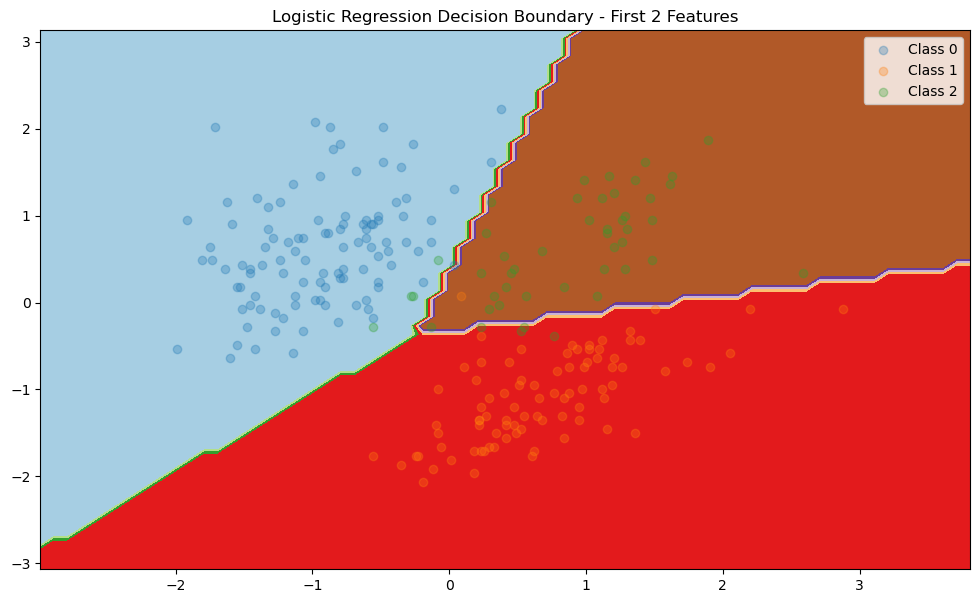

In [34]:
from sklearn.linear_model import LogisticRegression

# Model - usunięto przestarzały parametr multi_class
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
lr_metrics = evaluate_model(lr_model, 'Logistic Regression', 
                          X_train_scaled, X_test_scaled, 
                          y_train, y_test)

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Tworzymy osobny model tylko z dwiema cechami do wizualizacji
lr_model_2d = LogisticRegression(max_iter=1000, random_state=42)
lr_model_2d.fit(X_train_scaled[:, :2], y_train)
plot_classification_surface(X_train_scaled[:, :2], y_train, lr_model_2d, 
                          'Logistic Regression Decision Boundary - First 2 Features')

### 4.2. K-Najbliższych Sąsiadów (KNN)


Evaluation for K-Nearest Neighbors

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      1.00      1.00        37
           2       1.00      0.95      0.98        21

    accuracy                           0.99       103
   macro avg       0.99      0.98      0.99       103
weighted avg       0.99      0.99      0.99       103



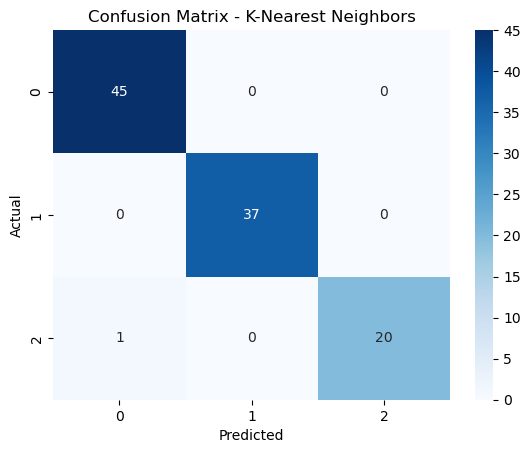

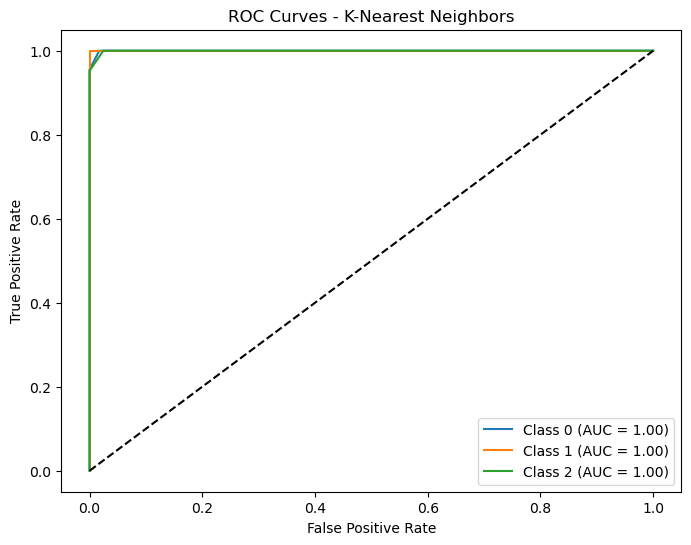


Accuracy: 0.9903


C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


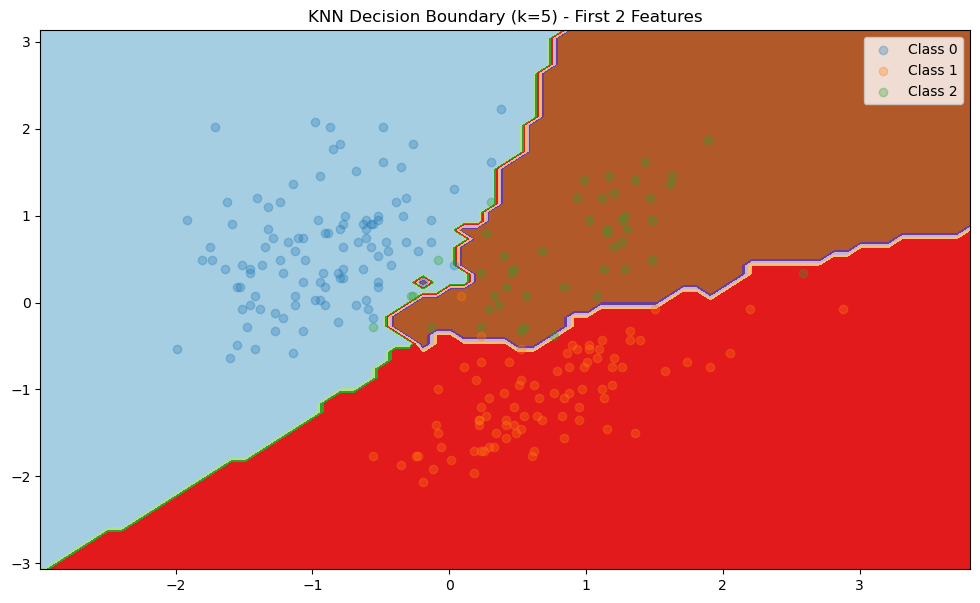

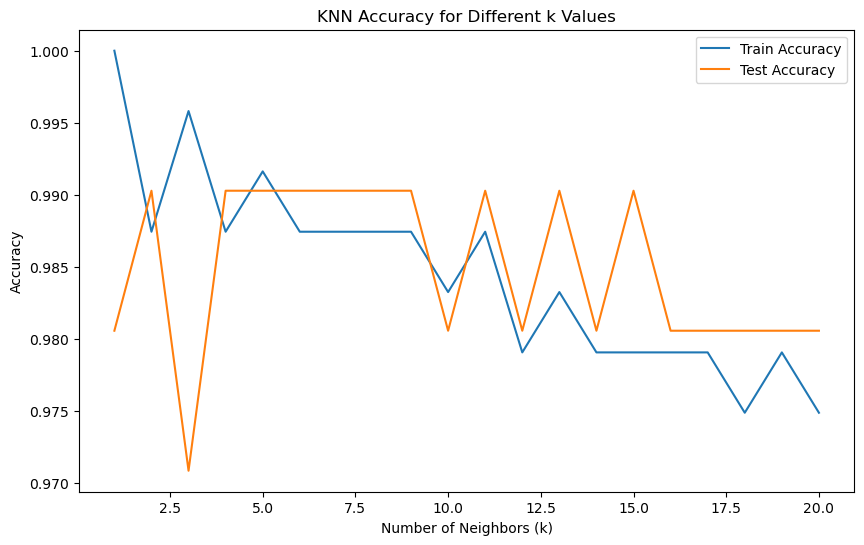

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
knn_metrics = evaluate_model(knn_model, 'K-Nearest Neighbors', 
                           X_train_scaled, X_test_scaled, 
                           y_train, y_test)

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Musimy przetrenować specjalny model tylko z dwiema cechami do wizualizacji
knn_model_2d = KNeighborsClassifier(n_neighbors=5)
knn_model_2d.fit(X_train_scaled[:, :2], y_train)
plot_classification_surface(X_train_scaled[:, :2], y_train, knn_model_2d, 
                          'KNN Decision Boundary (k=5) - First 2 Features')

# Optymalizacja parametru k
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(accuracy_score(y_train, knn.predict(X_train_scaled)))
    test_scores.append(accuracy_score(y_test, knn.predict(X_test_scaled)))

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, label='Train Accuracy')
plt.plot(k_values, test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k Values')
plt.legend()
plt.show()

### 4.3. Drzewo decyzyjne


Evaluation for Decision Tree

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        45
           1       1.00      0.97      0.99        37
           2       0.95      0.86      0.90        21

    accuracy                           0.95       103
   macro avg       0.95      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



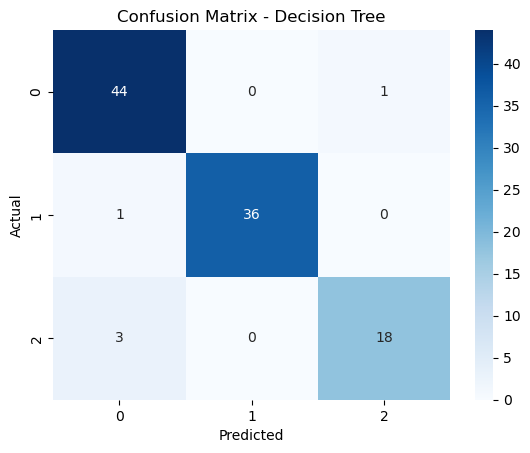

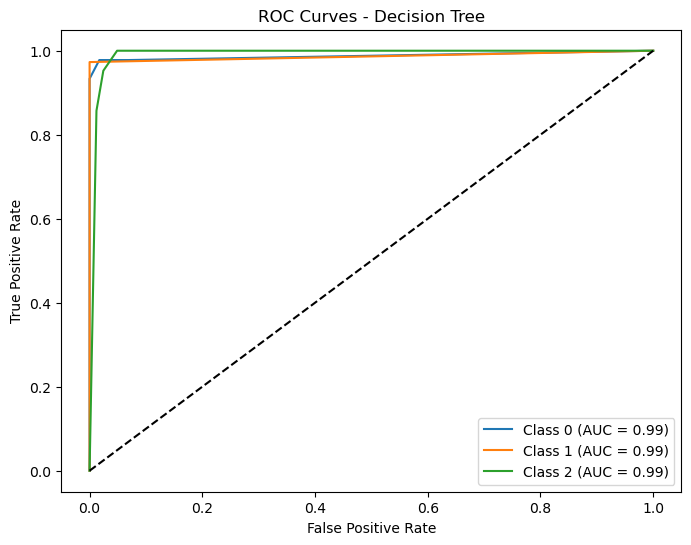


Accuracy: 0.9515


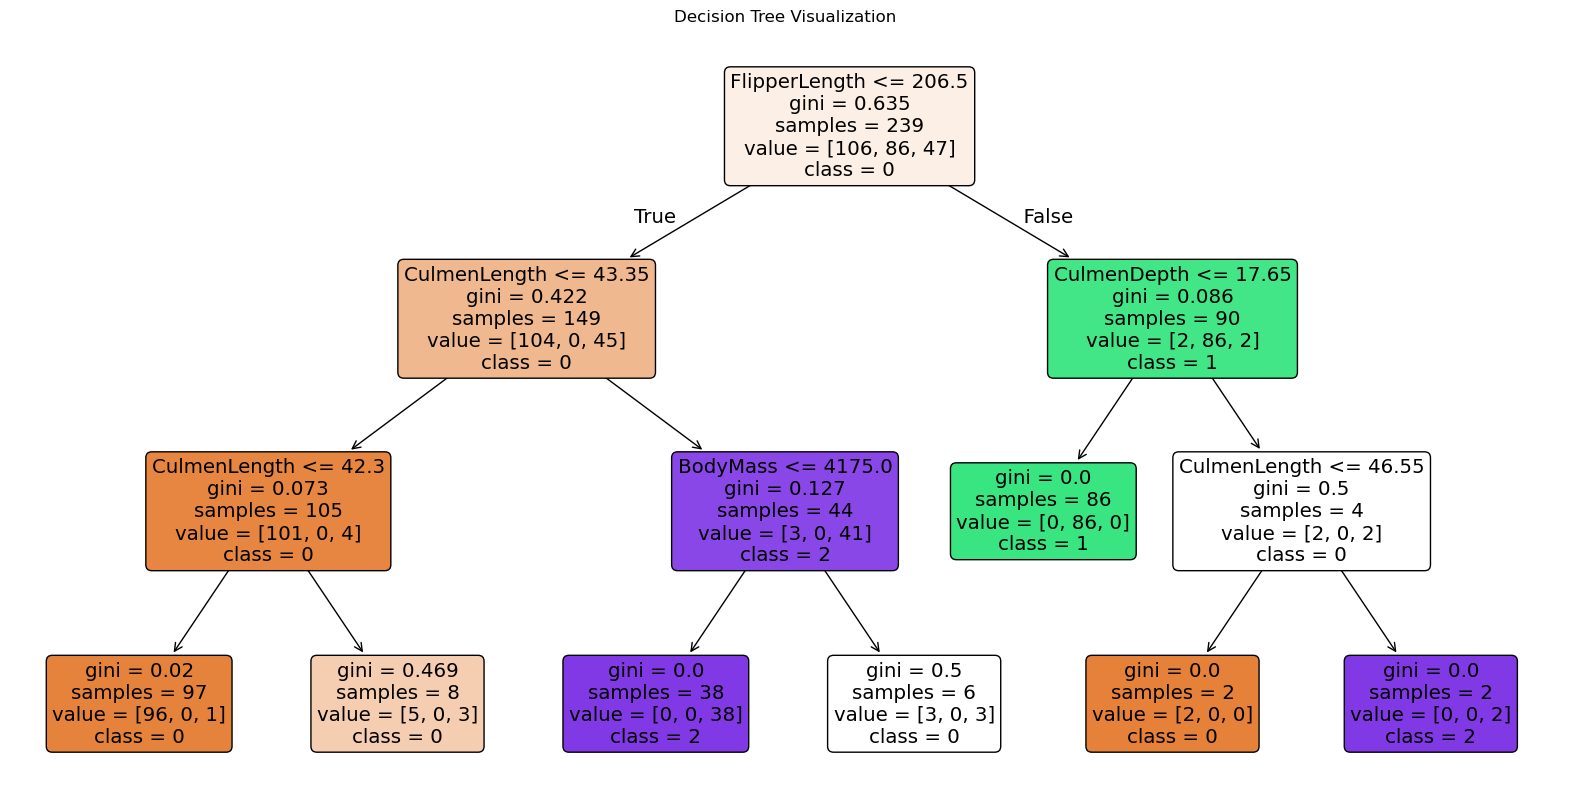

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


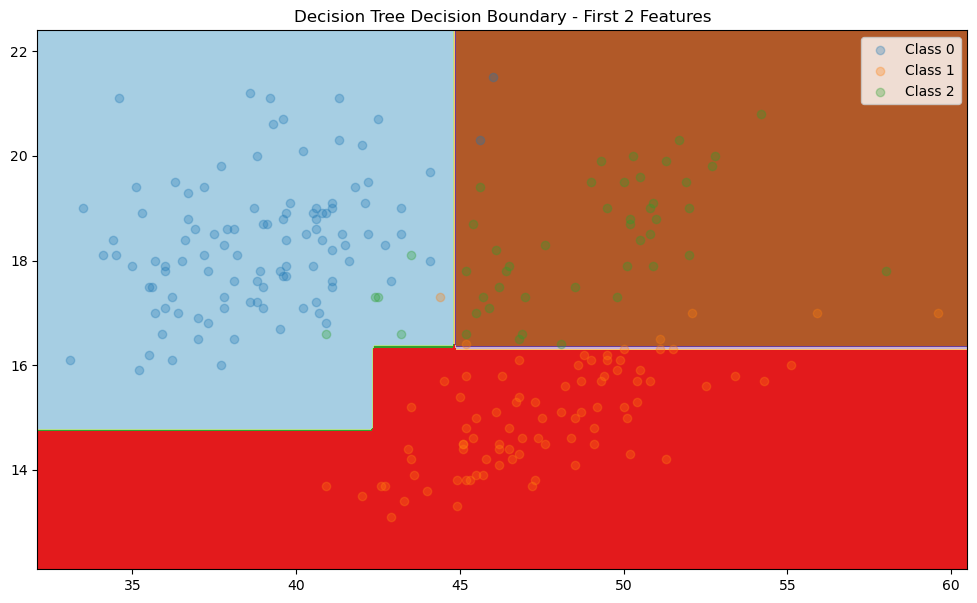

In [38]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
tree_metrics = evaluate_model(tree_model, 'Decision Tree', 
                            X_train, X_test, 
                            y_train, y_test)

# Wizualizacja drzewa
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=features, class_names=['0', '1', '2'], 
         filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Tworzymy osobny model tylko z dwiema cechami do wizualizacji
tree_model_2d = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model_2d.fit(X_train[features[:2]], y_train)
plot_classification_surface(X_train[features[:2]].values, y_train, tree_model_2d, 
                          'Decision Tree Decision Boundary - First 2 Features')

### 4.4. Random Forest


Evaluation for Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       1.00      0.97      0.99        37
           2       0.91      1.00      0.95        21

    accuracy                           0.98       103
   macro avg       0.97      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



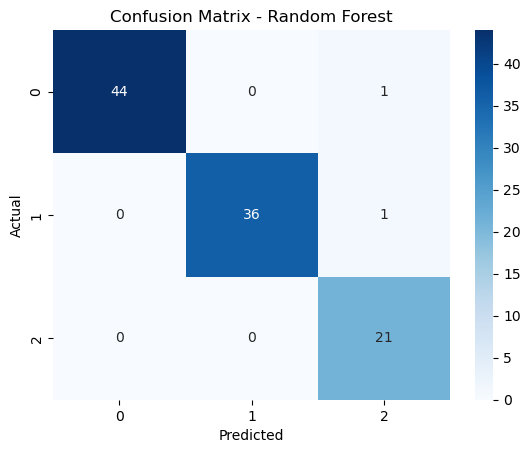

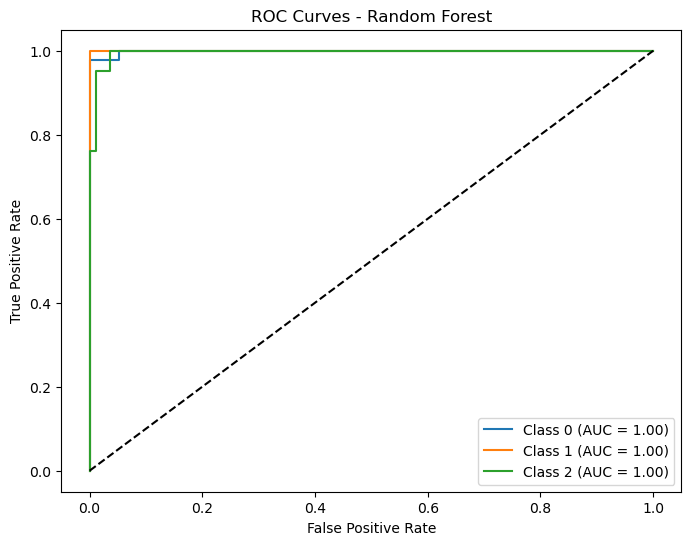


Accuracy: 0.9806


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


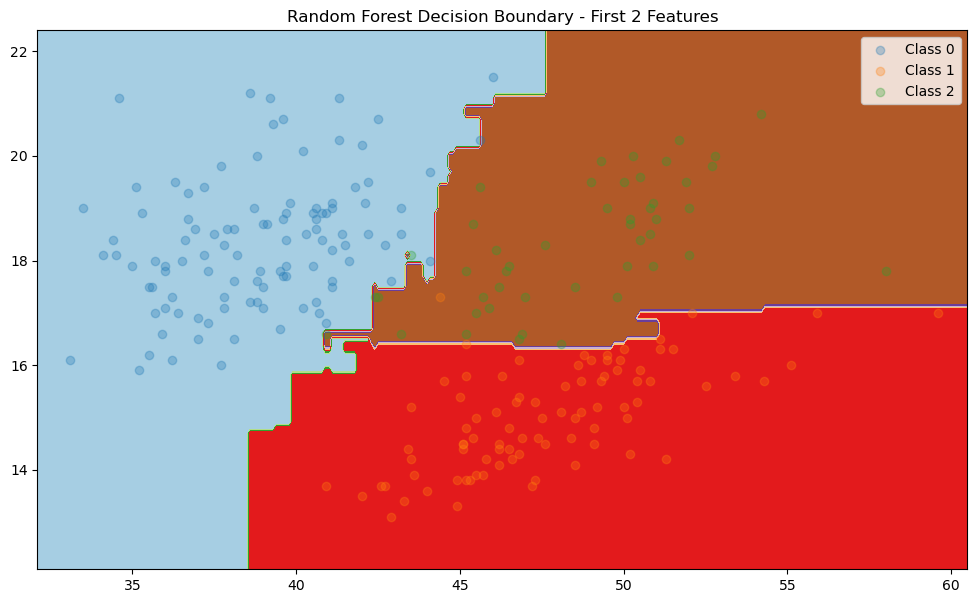

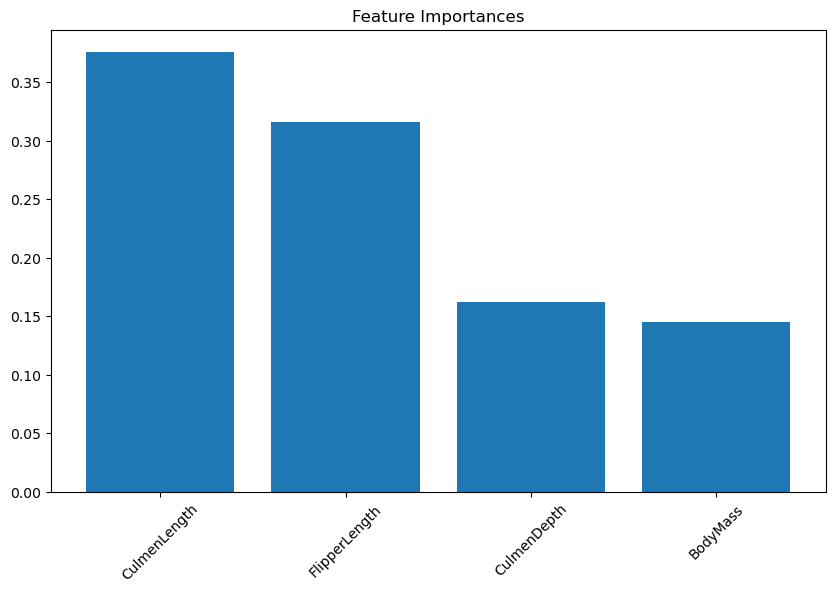


Najważniejsze cechy:
CulmenLength: 0.3758
FlipperLength: 0.3163
CulmenDepth: 0.1624
BodyMass: 0.1455


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
rf_metrics = evaluate_model(rf_model, 'Random Forest', 
                          X_train, X_test, 
                          y_train, y_test)

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Tworzymy osobny model tylko z dwiema cechami do wizualizacji
rf_model_2d = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model_2d.fit(X_train[features[:2]], y_train)
plot_classification_surface(X_train[features[:2]].values, y_train, rf_model_2d, 
                          'Random Forest Decision Boundary - First 2 Features')

# Ważność cech
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.show()

# Wyświetlenie najważniejszych cech
print("\nNajważniejsze cechy:")
for i in indices:
    print(f"{features[i]}: {importances[i]:.4f}")

### 4.5. Support Vector Machine (SVM)


Evaluation for Support Vector Machine

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       1.00      1.00      1.00        37
           2       0.95      0.95      0.95        21

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



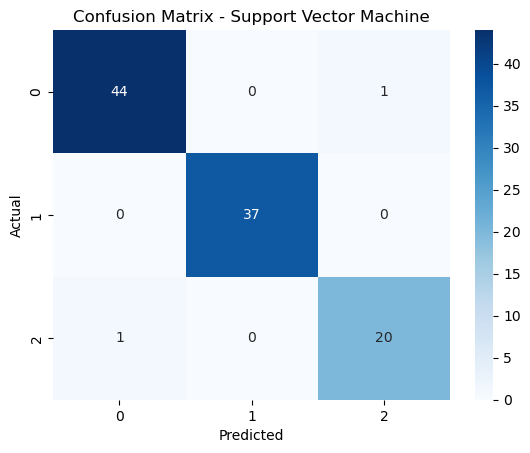

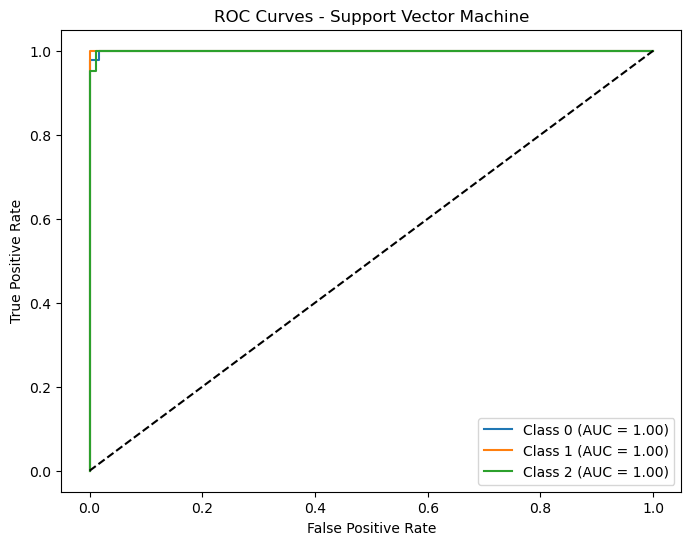


Accuracy: 0.9806


C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


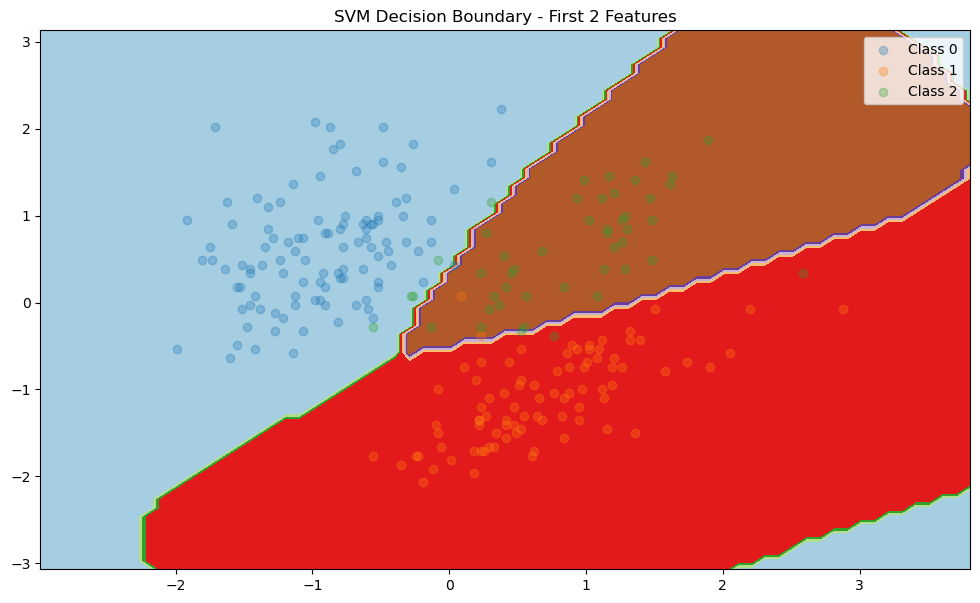

In [48]:
from sklearn.svm import SVC

# Model SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
svm_metrics = evaluate_model(svm_model, 'Support Vector Machine', 
                           X_train_scaled, X_test_scaled, 
                           y_train, y_test)

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Tworzymy osobny model tylko z dwiema cechami do wizualizacji
svm_model_2d = SVC(kernel='rbf', probability=True, random_state=42)
svm_model_2d.fit(X_train_scaled[:, :2], y_train)
plot_classification_surface(X_train_scaled[:, :2], y_train, svm_model_2d, 
                          'SVM Decision Boundary - First 2 Features')

### 4.6. AdaBoost

C:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Evaluation for AdaBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.81        45
           1       0.95      1.00      0.97        37
           2       1.00      0.05      0.09        21

    accuracy                           0.80       103
   macro avg       0.88      0.68      0.63       103
weighted avg       0.85      0.80      0.72       103



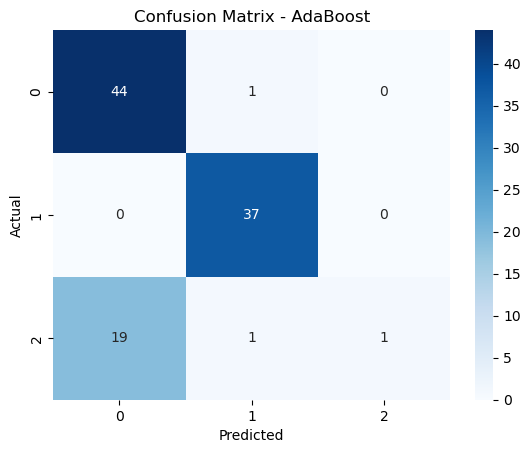

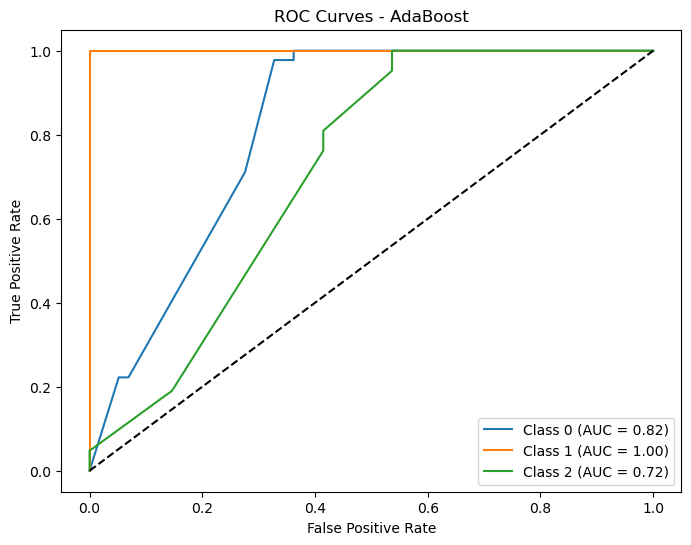


Accuracy: 0.7961


C:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


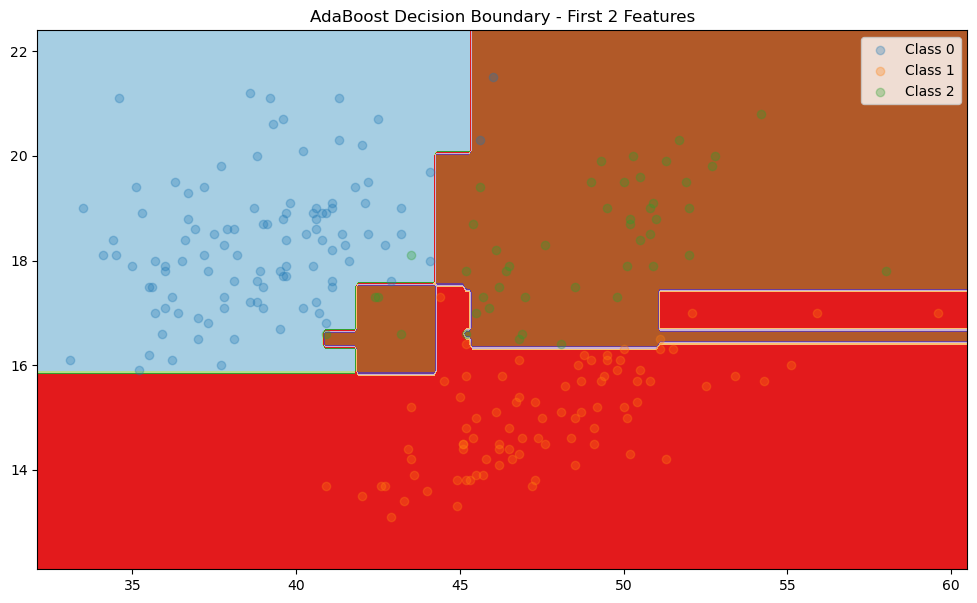

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Model AdaBoost - użyj estimator zamiast base_estimator
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada_model.fit(X_train, y_train)

# Ewaluacja na pełnym zbiorze cech (4 cechy)
ada_metrics = evaluate_model(ada_model, 'AdaBoost', 
                           X_train, X_test, 
                           y_train, y_test)

# Wizualizacja powierzchni decyzyjnej (tylko dla pierwszych dwóch cech)
# Tworzymy osobny model tylko z dwiema cechami do wizualizacji
ada_model_2d = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada_model_2d.fit(X_train[features[:2]], y_train)
plot_classification_surface(X_train[features[:2]].values, y_train, ada_model_2d, 
                          'AdaBoost Decision Boundary - First 2 Features')

## 5. Porównanie modeli

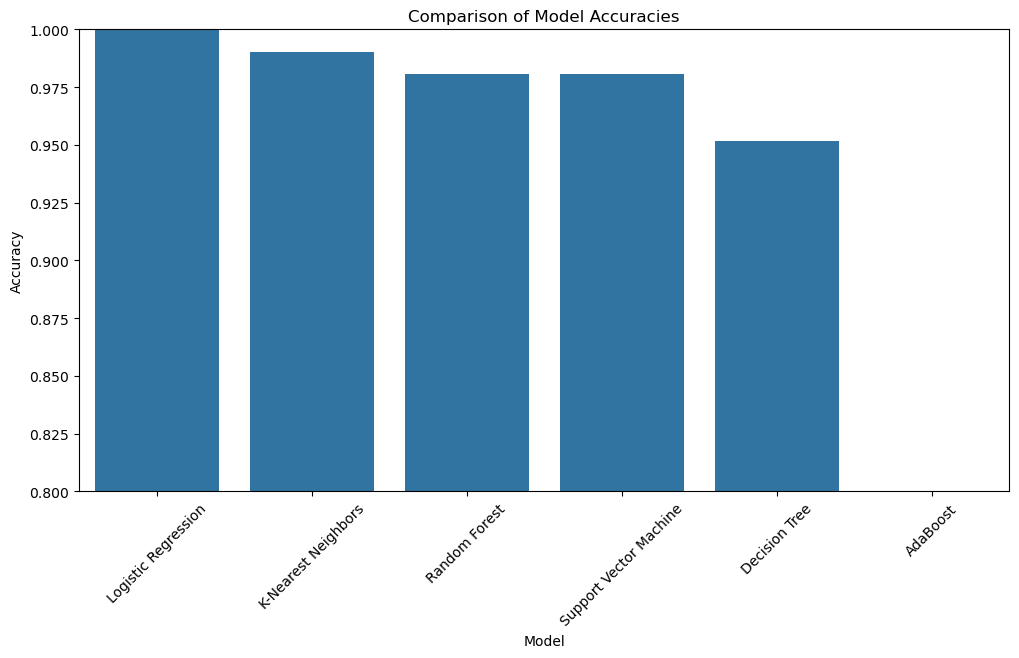

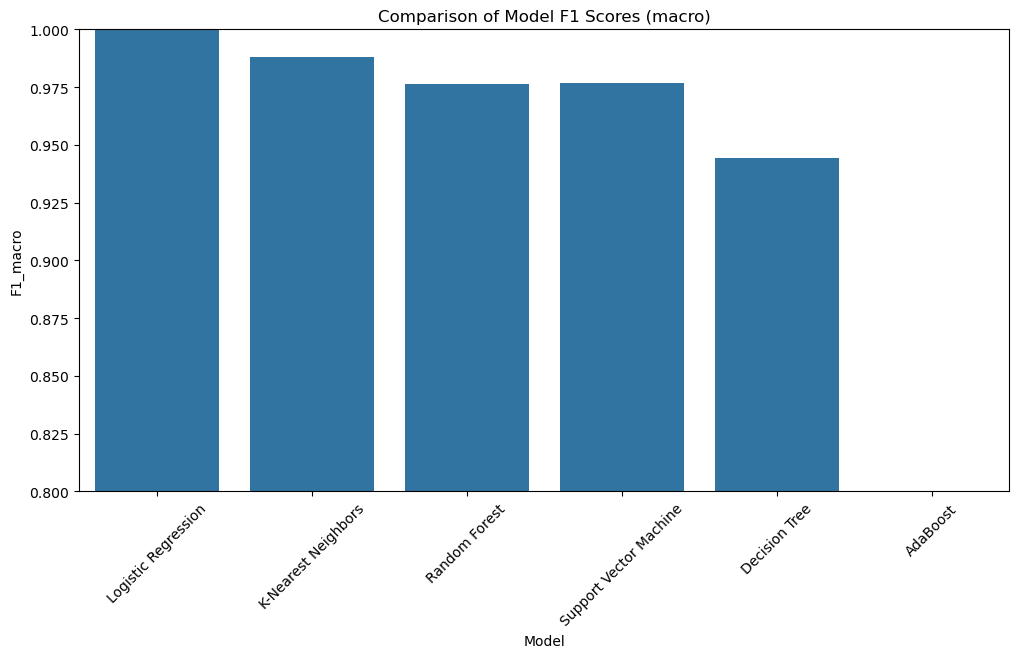


Final Model Comparison:
                    Model  Accuracy  F1_macro
0     Logistic Regression  1.000000  1.000000
1     K-Nearest Neighbors  0.990291  0.988207
3           Random Forest  0.980583  0.976537
4  Support Vector Machine  0.980583  0.976720
2           Decision Tree  0.951456  0.944179
5                AdaBoost  0.796117  0.626469


In [54]:
# Zebranie wyników wszystkich modeli
results = pd.DataFrame([lr_metrics, knn_metrics, tree_metrics, 
                       rf_metrics, svm_metrics, ada_metrics])

# Sortowanie po accuracy
results = results.sort_values('Accuracy', ascending=False)

# Wizualizacja porównania
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1_macro', data=results)
plt.title('Comparison of Model F1 Scores (macro)')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.show()

print("\nFinal Model Comparison:")
print(results)

## 6. Optymalizacja hiperparametrów dla najlepszego modelu

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Najlepsze parametry znalezione:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Evaluation for Optimized Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       1.00      1.00      1.00        37
           2       0.91      1.00      0.95        21

    accuracy                           0.98       103
   macro avg       0.97      0.99      0.98       103
weighted avg       0.98      0.98      0.98       103



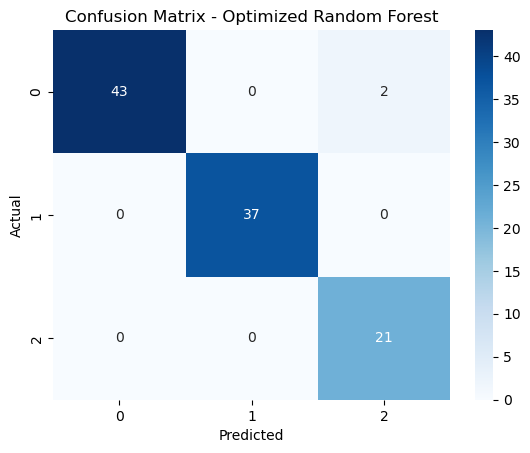

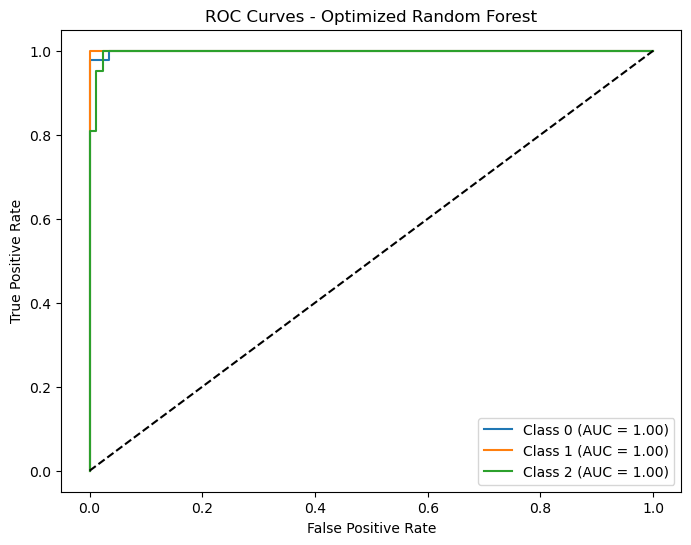


Accuracy: 0.9806


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_1776\1724439697.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=f'Class {class_value}')


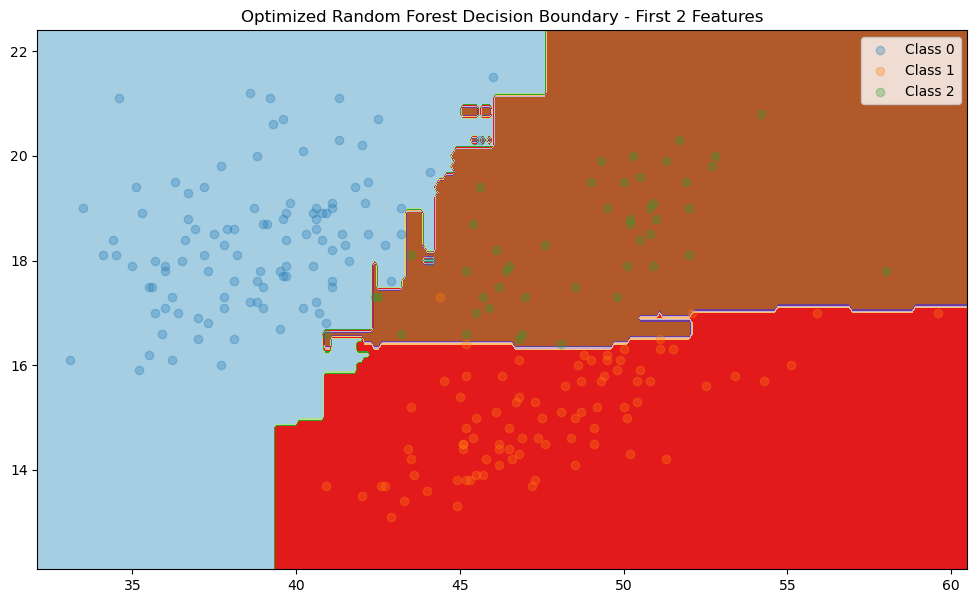


Finalne porównanie modeli z zoptymalizowanym Random Forest:
                     Model  Accuracy  F1_macro
0      Logistic Regression  1.000000  1.000000
1      K-Nearest Neighbors  0.990291  0.988207
2            Random Forest  0.980583  0.976537
3   Support Vector Machine  0.980583  0.976720
6  Optimized Random Forest  0.980583  0.977273
4            Decision Tree  0.951456  0.944179
5                 AdaBoost  0.796117  0.626469


In [58]:
from sklearn.model_selection import GridSearchCV

# Parametry do przeszukania
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model bazowy
rf = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf, 
                         param_grid=param_grid, 
                         cv=5, 
                         scoring='accuracy', 
                         n_jobs=-1, 
                         verbose=1)
grid_search.fit(X_train, y_train)

# Najlepsze parametry
print("\nNajlepsze parametry znalezione:")
print(grid_search.best_params_)

# Ewaluacja najlepszego modelu na pełnym zbiorze cech
best_rf = grid_search.best_estimator_
best_rf_metrics = evaluate_model(best_rf, 'Optimized Random Forest', 
                               X_train, X_test, 
                               y_train, y_test)

# Wizualizacja powierzchni decyzyjnej dla najlepszego modelu (tylko 2 cechy)
best_rf_2d = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_2d.fit(X_train[features[:2]], y_train)
plot_classification_surface(X_train[features[:2]].values, y_train, best_rf_2d, 
                          'Optimized Random Forest Decision Boundary - First 2 Features')

# Dodanie wyników do porównania
results = pd.concat([results, pd.DataFrame([best_rf_metrics])], ignore_index=True)

# Finalne porównanie
print("\nFinalne porównanie modeli z zoptymalizowanym Random Forest:")
print(results.sort_values('Accuracy', ascending=False))